In [7]:
import os
import torch 
import torch.nn as nn
import torchvision.transforms as transforms
from torch.nn.modules.container import Sequential
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
from torchvision import datasets
from torch.utils.data import DataLoader
import numpy as np
import datetime

In [2]:
device  = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
df = pd.read_csv(r'C:\Users\neele\OneDrive\Documents\Dataset\Smart_Meters\archive\halfhourly_dataset\halfhourly_dataset\block_0.csv', parse_dates=['tstp'])

In [5]:
df['energy(kWh/hh)'] = df['energy(kWh/hh)'].replace('Null', 0)
df['energy(kWh/hh)'] = df['energy(kWh/hh)'].astype(float)

In [6]:
df.head()

,LCLid,tstp,energy(kWh/hh)
0,MAC000002,2012-10-12 00:30:00,0.0
1,MAC000002,2012-10-12 01:00:00,0.0
2,MAC000002,2012-10-12 01:30:00,0.0
3,MAC000002,2012-10-12 02:00:00,0.0
4,MAC000002,2012-10-12 02:30:00,0.0


In [10]:
df_train = df[(df['tstp'] > datetime.datetime(2013,1,1)) & (df['tstp'] < datetime.datetime(2014,1,1)) & (df['LCLid'] == "MAC000002")]
df_test = df[(df['tstp'] > datetime.datetime(2014,1,1)) & (df['LCLid'] == "MAC000002")]

In [14]:
training_mean = df_train['energy(kWh/hh)'].mean()
training_std = df_train['energy(kWh/hh)'].std()

df_training_values = (df_train['energy(kWh/hh)'] - training_mean) / training_std

print("Number of training examples : ", len(df_training_values))

Number of training examples :  17519


In [15]:
test_mean = df_test['energy(kWh/hh)'].mean()
test_std = df_test['energy(kWh/hh)'].std()

df_testing_values = (df_test['energy(kWh/hh)'] - test_mean) / test_std

print("Number of training examples : ", len(df_testing_values))

Number of training examples :  2783


In [16]:
def create_sequences(values, time_step = 48):
    
    output = []

    for i in range(0, len(values) - time_step+1, time_step):
        output.append(values[i:(i+time_step)])

    return np.stack(output)

In [17]:
x_train = create_sequences(df_training_values.values)
x_test = create_sequences(df_testing_values.values)

print("Training input shape : ", x_train.shape)
print("Test input shape : ", x_test.shape)

Training input shape :  (364, 48)
Test input shape :  (57, 48)


In [18]:
x_train_float = x_train.astype(np.float32).tolist()
train_loader = [torch.tensor(s).unsqueeze(1).float() for s in x_train_float]

x_test_float = x_test.astype(np.float32).tolist()
test_loader = [torch.tensor(s).unsqueeze(1).float() for s in x_test_float]

In [19]:
class Encoder(nn.Module):

    def __init__(self, sequence_length, number_of_features, embedding_dimension = 64):
        super(Encoder, self).__init__()

        self.sequence_length = sequence_length
        self.number_of_features = number_of_features

        self.embedding_dimension = embedding_dimension
        self.hidden_layer_dimension = 2 * embedding_dimension

        self.lstm1 = nn.LSTM(input_size = self.number_of_features, hidden_size = self.hidden_layer_dimension, num_layers = 1, batch_first = True)

        self.lstm2 = nn.LSTM(input_size = self.hidden_layer_dimension, hidden_size = self.embedding_dimension, num_layers = 1, batch_first = True)

    def forward(self, x):
        x = x.reshape((1, self.sequence_length, self.number_of_features))

        x, (_,_) = self.lstm1(x)
        x, (hidden_n,_) = self.lstm2(x)

        return hidden_n.reshape((self.number_of_features, self.embedding_dimension))

In [27]:
class Decoder(nn.Module):

    def __init__(self, sequence_length, input_dimension = 64, number_of_features = 1):
        super(Decoder, self).__init__()

        self.sequence_length = sequence_length
        self.number_of_features = number_of_features

        self.input_dimension = input_dimension
        self.hidden_layer_dimension = 2 * input_dimension

        self.lstm1 = nn.LSTM(input_size = self.input_dimension, hidden_size = self.input_dimension, num_layers = 1, batch_first = True)

        self.lstm2 = nn.LSTM(input_size = self.input_dimension, hidden_size = self.hidden_layer_dimension, num_layers = 1, batch_first = True)

        self.output_layer = nn.Linear(self.hidden_layer_dimension, self.number_of_features)

    def forward(self, x):
        x = x.repeat(self.sequence_length, self.number_of_features)
        x = x.reshape((self.number_of_features, self.sequence_length, self.input_dimension))

        x, (hidden_n,cell_n) = self.lstm1(x)
        x, (hidden_n,cell_n ) = self.lstm2(x)
        x = x.reshape((self.sequence_length, self.hidden_layer_dimension))

        return self.output_layer(x)

In [28]:
class AutoEncoder(nn.Module):

    def __init__(self, sequence_length, number_of_features, embedding_dimension = 64):
        super(AutoEncoder, self).__init__()

        self.encoder = Encoder(sequence_length, number_of_features, embedding_dimension).to(device)
        self.decoder = Decoder(sequence_length, embedding_dimension, number_of_features).to(device)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        return x

In [29]:
model = AutoEncoder(48,1,8).to(device)
print(model)

AutoEncoder(
  (encoder): Encoder(
    (lstm1): LSTM(1, 16, batch_first=True)
    (lstm2): LSTM(16, 8, batch_first=True)
  )
  (decoder): Decoder(
    (lstm1): LSTM(8, 8, batch_first=True)
    (lstm2): LSTM(8, 16, batch_first=True)
    (output_layer): Linear(in_features=16, out_features=1, bias=True)
  )
)


In [42]:
epochs = 1000
lr = 1e-3
batch_size = 64


In [32]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = lr)

In [38]:
def training():
    training_loss = []
    for epoch in range(epochs):
        running_loss = 0.0

        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, data)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        loss = running_loss / len(train_loader)
        training_loss.append(loss)
        print("Epoch {} of {}, Train Loss: {:.3f}".format(epoch+1, epochs, loss))

    return train_loss

In [43]:
train_loss = training()

Epoch 1 of 100, Train Loss: 0.389
Epoch 2 of 100, Train Loss: 0.381
Epoch 3 of 100, Train Loss: 0.375
Epoch 4 of 100, Train Loss: 0.373
Epoch 5 of 100, Train Loss: 0.386
Epoch 6 of 100, Train Loss: 0.379
Epoch 7 of 100, Train Loss: 0.374
Epoch 8 of 100, Train Loss: 0.389
Epoch 9 of 100, Train Loss: 0.377
Epoch 10 of 100, Train Loss: 0.394
Epoch 11 of 100, Train Loss: 0.391
Epoch 12 of 100, Train Loss: 0.379
Epoch 13 of 100, Train Loss: 0.408
Epoch 14 of 100, Train Loss: 0.391
Epoch 15 of 100, Train Loss: 0.373
Epoch 16 of 100, Train Loss: 0.367
Epoch 17 of 100, Train Loss: 0.372
Epoch 18 of 100, Train Loss: 0.381
Epoch 19 of 100, Train Loss: 0.374
Epoch 20 of 100, Train Loss: 0.418
Epoch 21 of 100, Train Loss: 0.381
Epoch 22 of 100, Train Loss: 0.393
Epoch 23 of 100, Train Loss: 0.381
Epoch 24 of 100, Train Loss: 0.372
Epoch 25 of 100, Train Loss: 0.380
Epoch 26 of 100, Train Loss: 0.359
Epoch 27 of 100, Train Loss: 0.381
Epoch 28 of 100, Train Loss: 0.372
Epoch 29 of 100, Train Loss: 

In [46]:
plt.figure()
plt.plot(train_loss)
plt.xlabel("Epochs")
plt.ylabel("Loss")

In [49]:
def predict(model, dataset):
    predictiones, losses = [], []
    with torch.no_grad():
        model = model.eval()
        for seq_true in dataset:
            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)

            loss = criterion(seq_pred, seq_true)

            predictiones.append(seq_pred.cpu().numpy().flatten())

            losses.append(loss.item())

    return predictiones, losses

In [58]:
x_test_pred, _ = predict(model, test_loader)

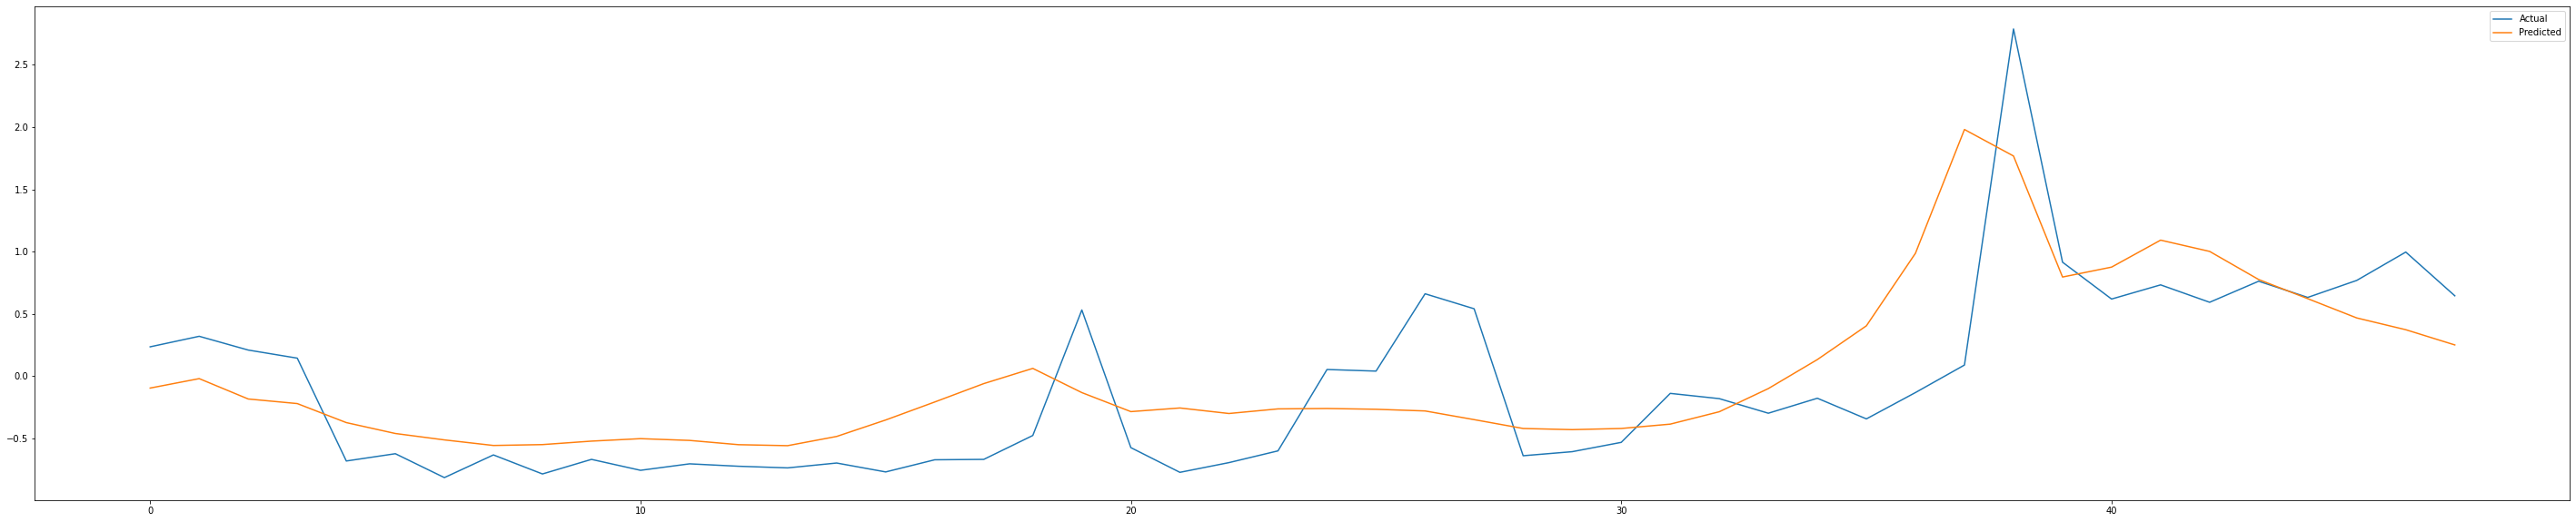

In [70]:
plt.figure(figsize=(50,10))
plt.plot(x_test[5], label='Actual')
plt.plot(x_test_pred[5], label="Predicted")
plt.legend(loc='upper right')
plt.show()